# **Convolutional Neural Network** 

## **Setup**

In [1]:
import sys 
assert sys.version_info >= (3, 5) 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

import sklearn 
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras 
from keras.datasets import mnist
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop

In [2]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)

if not current_directory.endswith('/Handwritten-digit-recognition'):
    path_parts = current_directory.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        if path_parts[i - 1] == 'Handwritten-digit-recognition':
            new_directory = os.sep.join(path_parts[:i])
            os.chdir(new_directory)
            break
    else:
        print("Directory 'Handwritten-digit-recognition' not found in the current path.")
else:
    print("Already in the correct directory.")

print("New Directory:", os.getcwd())


Current Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition\Src
New Directory: c:\Users\ASUS\OneDrive\Desktop\Handwritten-digit-recognition


In [3]:
# Where to save the figures 
PROJECT_ROOT_DIR = "."
FOLDER_ID = "handwritten digit recognition"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure" , fig_id)
    if tight_layout: 
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Data preparation**

### **Load dataset**

In [4]:
train = pd.read_csv('datasets/digit-recognizer/train.csv')
test = pd.read_csv('datasets/digit-recognizer/test.csv')
sub = pd.read_csv('datasets/digit-recognizer/sample_submission.csv')

print("Loading data successful!!")

Loading data successful!!


### **Load more data sets**

In [5]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

x_train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

X_train1 = x_train1.reshape(-1, 28*28)
Y_train1 = y_train1
Y_train1.shape, X_train1.shape
train1 = pd.DataFrame(np.column_stack((Y_train1, X_train1)), columns=train.columns)

In [6]:
# Merging all the data we got 
train = pd.DataFrame(np.concatenate((train, train1)), columns = train.columns)

In [7]:
X_train = train.drop(labels=["label"], axis=1)
Y_train = train["label"]

### **Normalization**

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover, the CNN converge faster on [0, 1] data than on [0, 255]

In [8]:
# Normalize data to make CNN faster 
X_train = X_train / 255.0
test = test / 255.0

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale

X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [10]:
# Convert label to one hot vectors (eg: 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0])
Y_train = to_categorical(Y_train, num_classes=10)

*Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors **(ex : 1 -> [0,1,0,0,0,0,0,0,0,0])**.*

In [11]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Define the model**

### **Split training and validation set**

In [12]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

In [13]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

In [14]:
# Define a function to create the Keras model
def create_cnn_model(optimizer='adam', activation="relu", learning_rate=0.001):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
        
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (5, 5), activation=activation, input_shape=(28, 28, 1), padding="same"),
        Conv2D(32, (5, 5), activation=activation, padding="same"),
        MaxPooling2D((2, 2), strides=2, padding='same'),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation=activation, padding='same'),
        Conv2D(64, (3, 3), activation=activation, padding='same'),
        MaxPooling2D((2, 2), strides=2, padding='same'),
        
        # Third Convolutional Layer
        Conv2D(128, (3, 3), activation=activation, padding='same'),
        Conv2D(128, (3, 3), activation=activation, padding='same'),
        MaxPooling2D((2, 2), strides=2, padding='same'),

        # Fully Connected Layers
        Flatten(),
        Dense(625, activation=activation),
        Dropout(0.2),
        Dense(10, activation='softmax')  # Assuming 10 classes for classification
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model 

In [15]:
# Create a KerasClassifier wrapper for Scikit-learn
batch_size = 128
epochs = 20
cnn = KerasClassifier(build_fn=create_cnn_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [16]:
# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__learning_rate': [0.001, 0.005, 0.01]
}

### **Hyperparameter tuning using GridSearchCV**

In [17]:
# import warnings
# warnings.filterwarnings('ignore')

# # Use GridSearchCV to find the best combination of hyperparameters
# grid = GridSearchCV(estimator=cnn, param_grid=param_grid, cv=3, verbose=2)
# grid_result = grid.fit(X_train, Y_train)

# Best Parameters: {'model__activation': 'relu', 'model__learning_rate': 0.001, 'optimizer': 'rmsprop'}
# Best Accuracy: 0.9949107142857144

In [18]:
# # Display the best hyperparameters and corresponding accuracy
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Accuracy: {grid_result.best_score_}")

# Best Parameters: {'model__activation': 'relu', 'model__learning_rate': 0.001, 'optimizer': 'rmsprop'}
# Best Accuracy: 0.9949107142857144

In [19]:
cnn = create_cnn_model(optimizer='rmsprop', learning_rate=0.001, activation='relu')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 625)            │     1,280,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 625)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         6,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,213 (6.07 MB)

 Trainable params: 1,590,213 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="FinalModels/CNN.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        verbose=1),
]

In [22]:
H = cnn.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks
)


Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8468 - loss: 0.4527
Epoch 1: val_loss improved from inf to 0.04231, saving model to FinalModels/CNN.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.8469 - loss: 0.4523 - val_accuracy: 0.9864 - val_loss: 0.0423
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9903 - loss: 0.0312
Epoch 2: val_loss improved from 0.04231 to 0.02291, saving model to FinalModels/CNN.keras
788/788 ━━━━━━━━━━━━━━━━━━━━ 107s 136ms/step - accuracy: 0.9903 - loss: 0.0312 - val_accuracy: 0.9935 - val_loss: 0.0229
Epoch 3/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9940 - loss: 0.0193
Epoch 3: val_loss did not improve from 0.02291
788/788 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - accuracy: 0.9940 - loss: 0.0193 - val_accuracy: 0.9904 - val_loss: 0.0385
Epoch 4/20
787/788 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9959 - loss: 0.0139
Epoch 4: val_loss improved from 0.02291 to 0.01510, saving model to F

Saving figure Final CNN History image


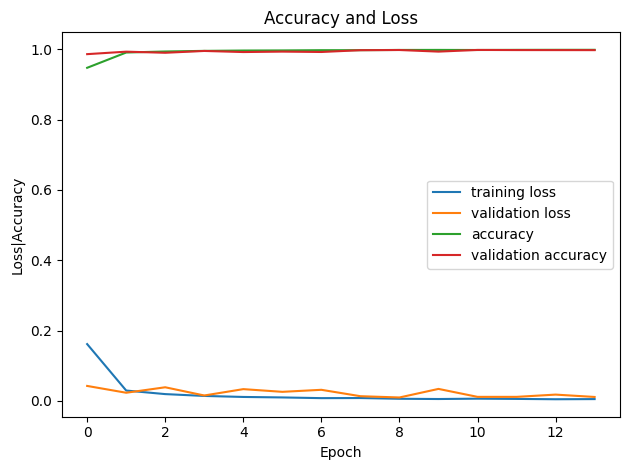

In [23]:
fig = plt.figure()
numOfEpoch = 14
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()
save_fig('Final CNN History image')

## **Load the model**

In [24]:
cnn = keras.saving.load_model("FinalModels/CNN.keras")

### **Predict some examples**

In [25]:
predictions = cnn.predict(test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


Prediction:  2


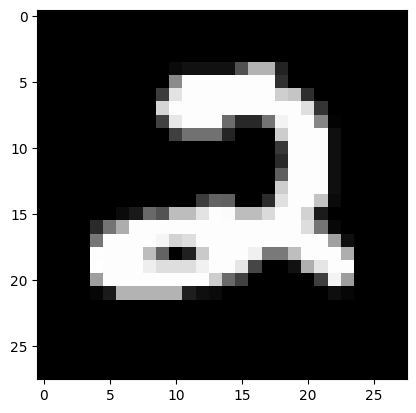

Prediction:  9


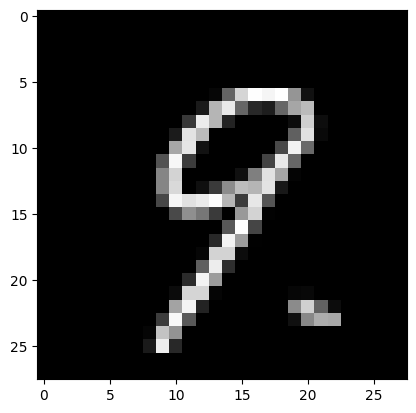

Prediction:  3


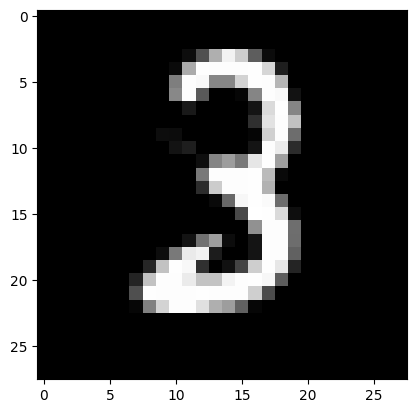

Prediction:  0


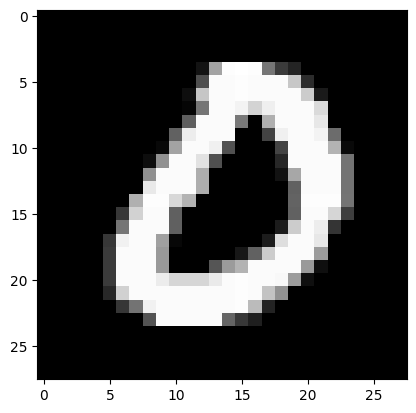

Prediction:  0


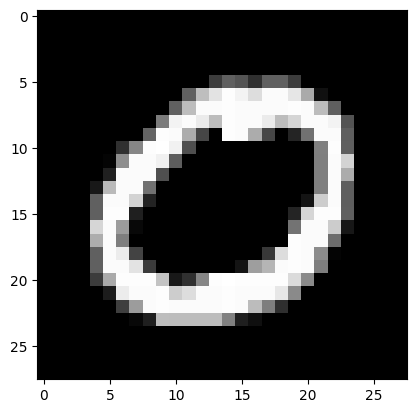

Prediction:  5


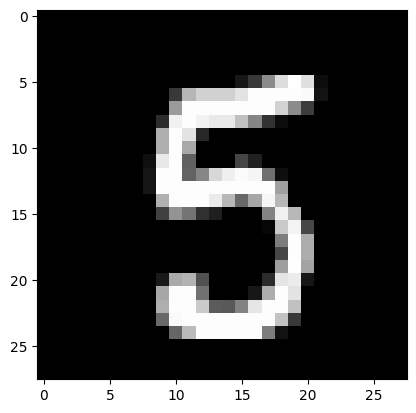

Prediction:  4


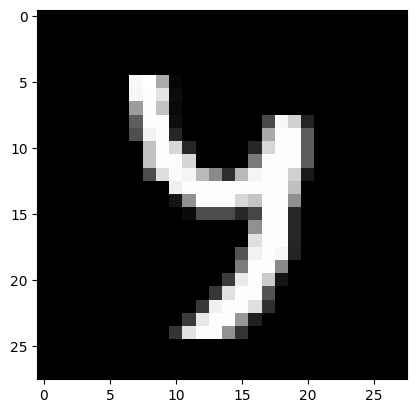

Prediction:  4


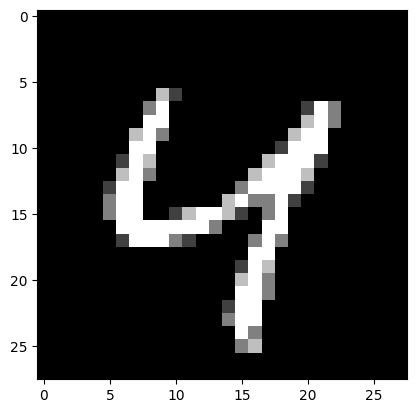

Prediction:  3


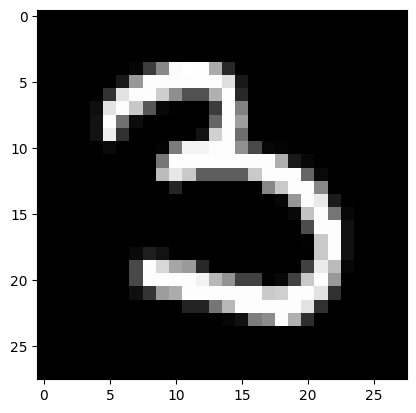

Prediction:  9


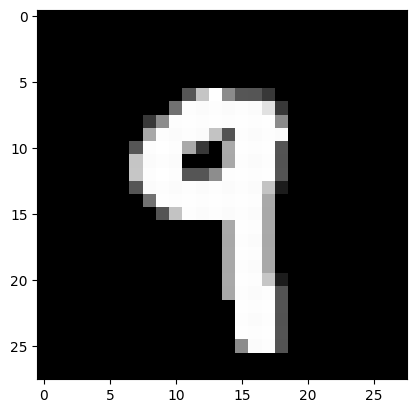

Prediction:  9


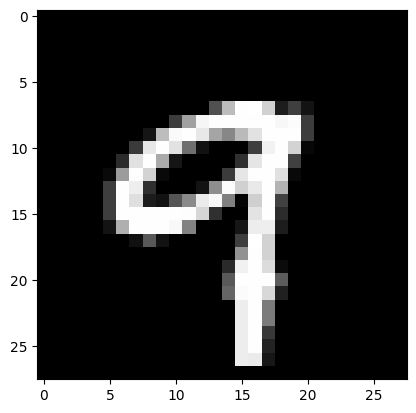

Prediction:  1


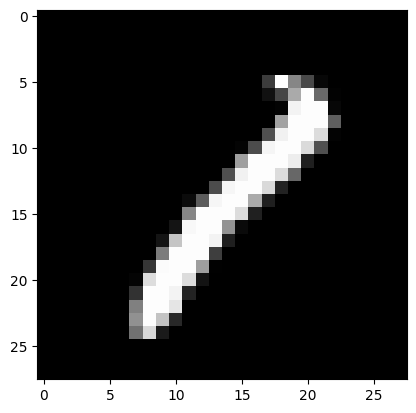

Prediction:  7


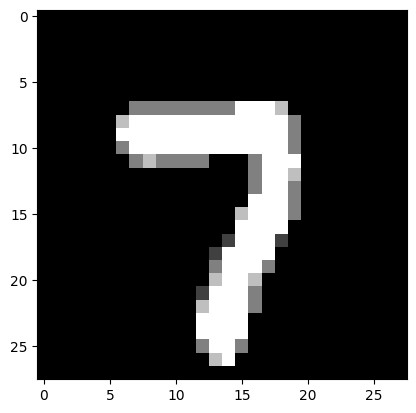

Prediction:  2


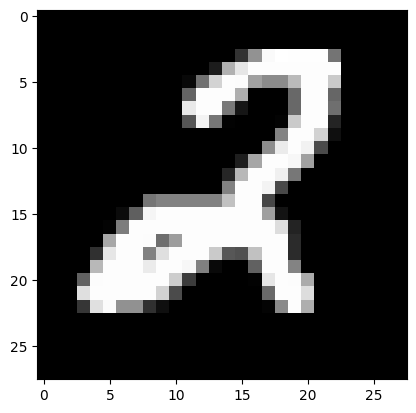

Prediction:  4


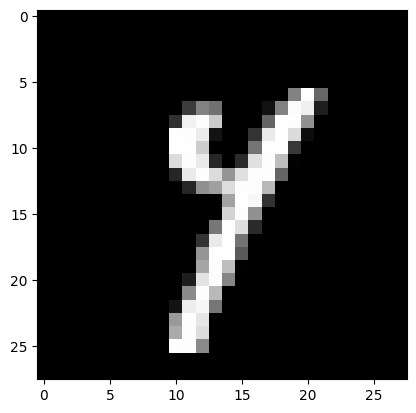

Prediction:  7


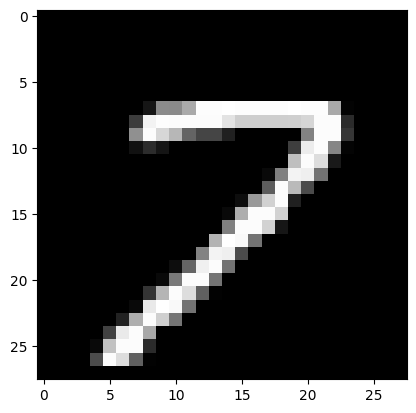

Prediction:  4


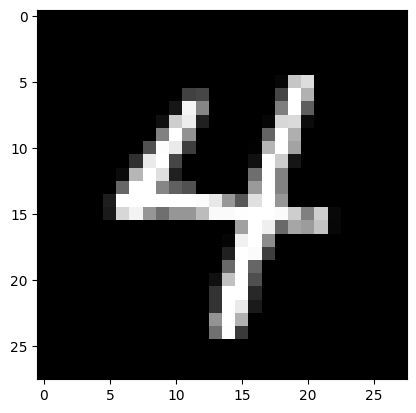

Prediction:  6


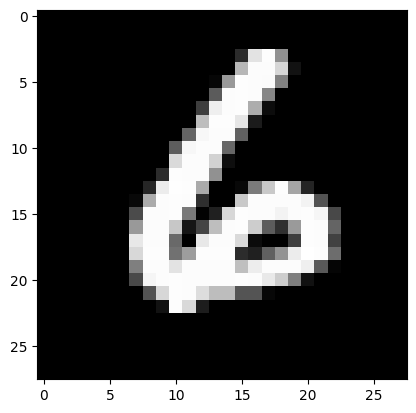

Prediction:  5


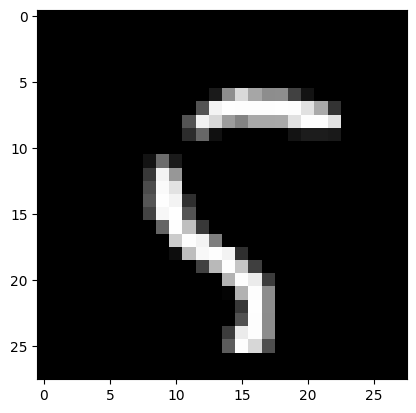

Prediction:  1


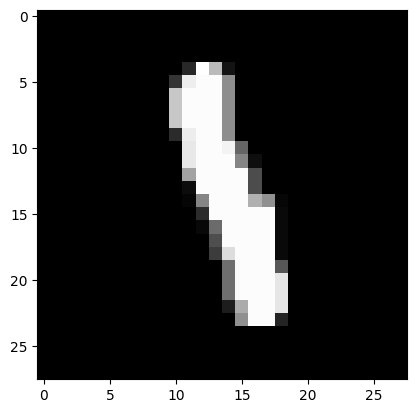

Prediction:  7


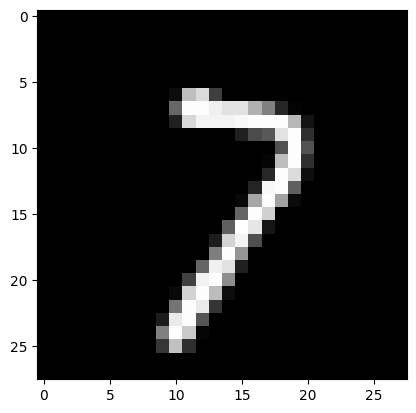

Prediction:  4


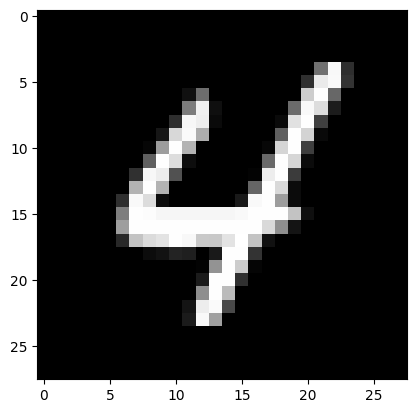

Prediction:  8


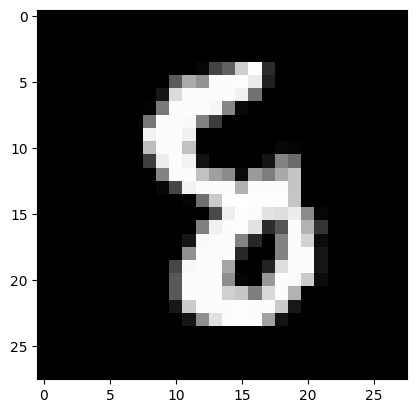

Prediction:  8


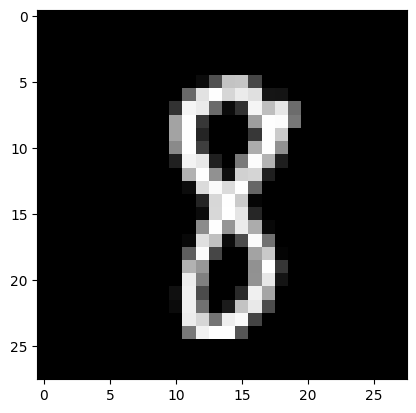

Prediction:  6


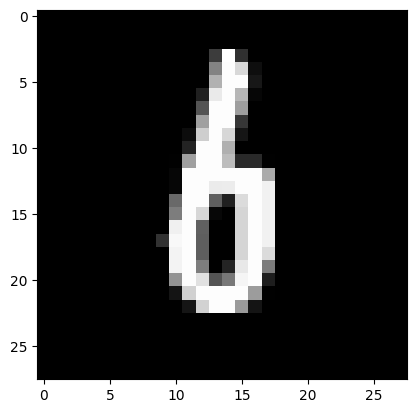

Prediction:  6


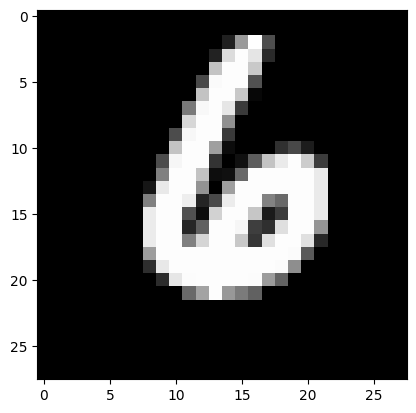

Prediction:  8


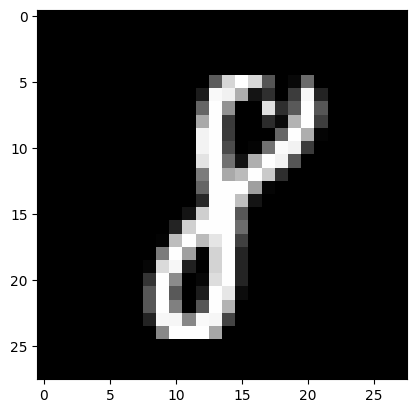

Prediction:  8


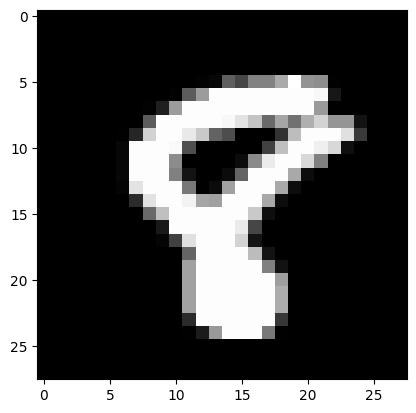

Prediction:  1


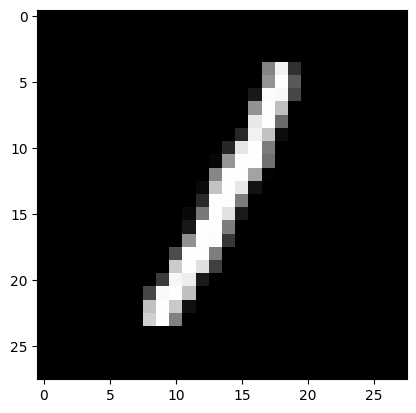

Prediction:  2


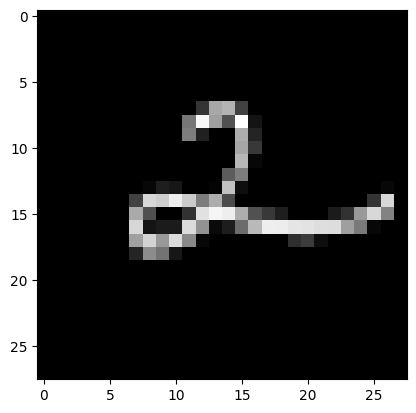

Prediction:  4


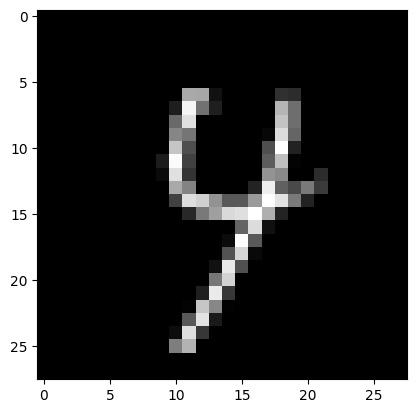

Prediction:  7


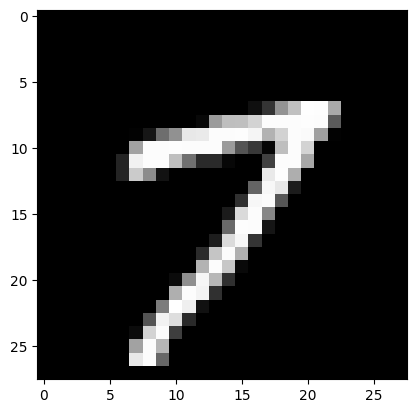

Prediction:  0


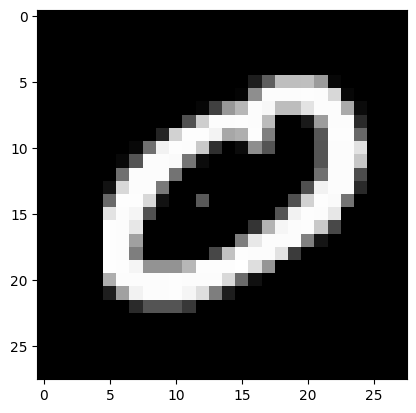

Prediction:  1


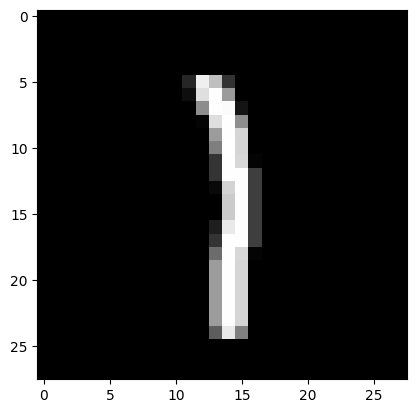

Prediction:  0


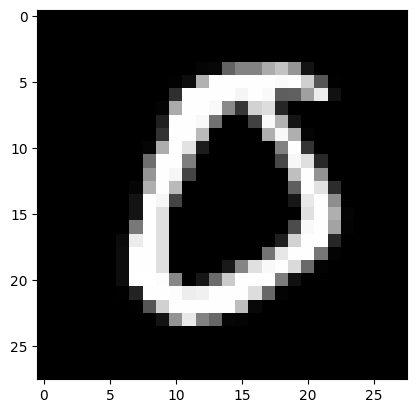

Prediction:  6


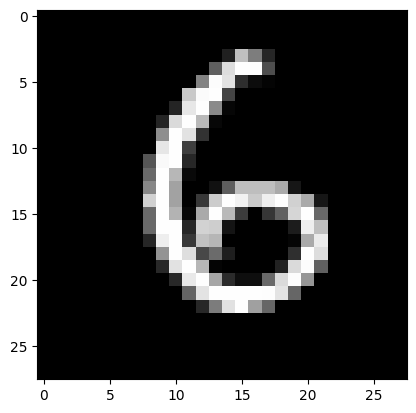

Prediction:  8


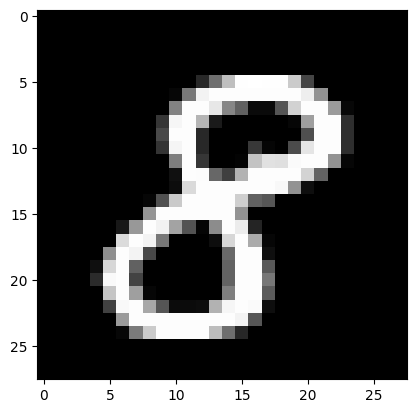

Prediction:  2


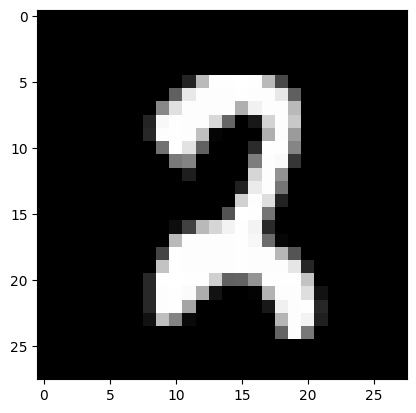

Prediction:  9


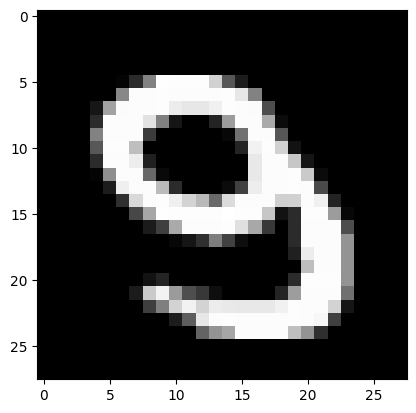

Prediction:  2


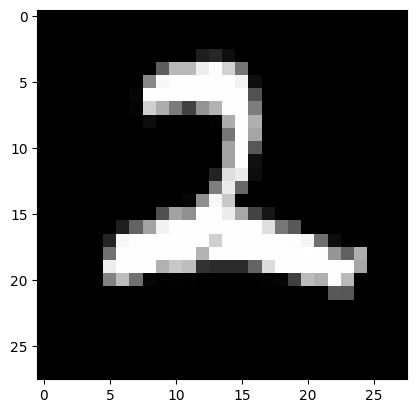

Prediction:  5


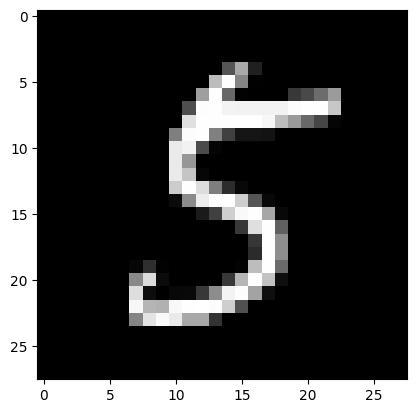

Prediction:  1


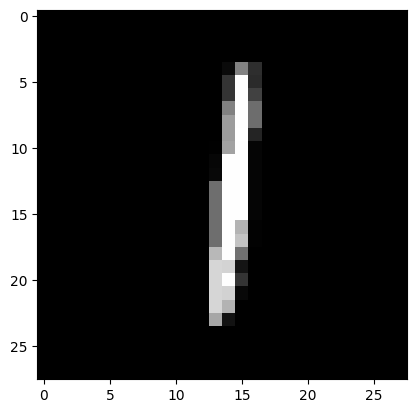

Prediction:  9


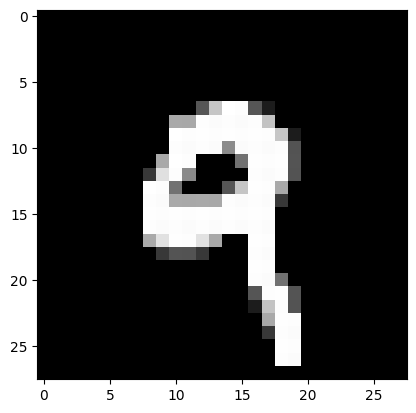

Prediction:  4


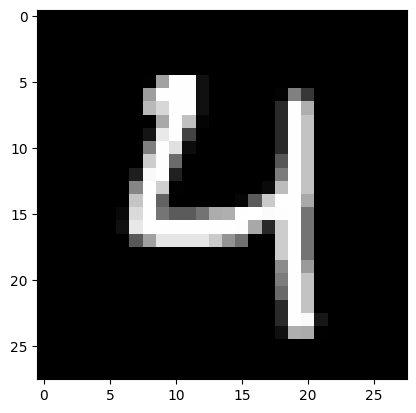

Prediction:  6


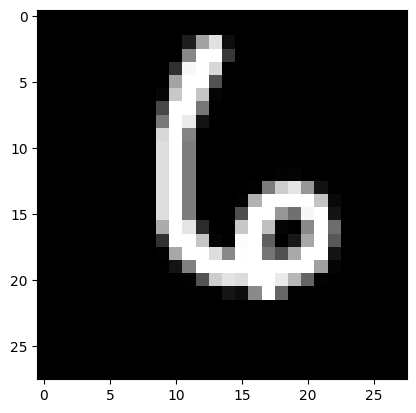

Prediction:  2


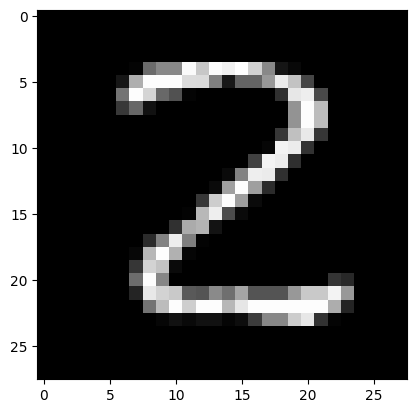

Prediction:  6


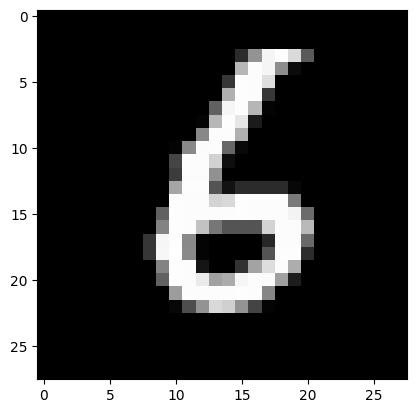

Prediction:  1


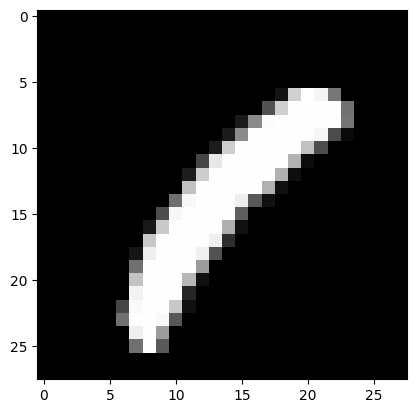

Prediction:  3


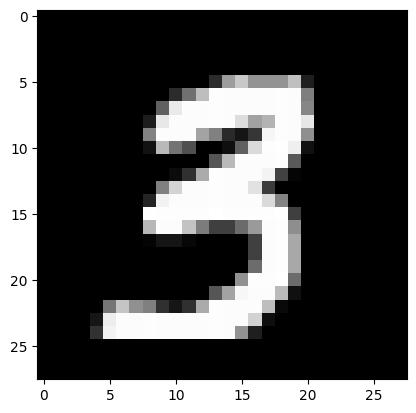

Prediction:  7


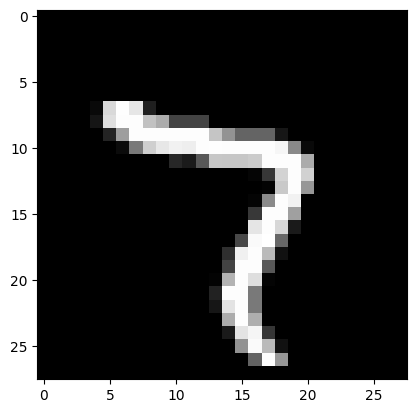

In [26]:
import matplotlib.pyplot as plt 
import numpy as np 

for i in range(0, 100, 2):
    print("Prediction: ", np.argmax(predictions[i]))
    
    shape =(28, 28)
    cmap = plt.get_cmap('gray')
    plt.imshow(np.reshape(test[i], shape), cmap=cmap)
    plt.show()

## **Evaluation**

In [27]:
cnn.evaluate(X_val, Y_val, verbose=1)

350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9976 - loss: 0.0091


[0.00943442527204752, 0.9982143044471741]

In [28]:
Y_pred = cnn.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
print(classification_report(Y_true, Y_pred_classes))

350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1116
           1       1.00      1.00      1.00      1244
           2       1.00      1.00      1.00      1094
           3       1.00      1.00      1.00      1185
           4       1.00      1.00      1.00      1073
           5       1.00      1.00      1.00      1035
           6       1.00      1.00      1.00      1111
           7       1.00      1.00      1.00      1163
           8       1.00      1.00      1.00      1080
           9       1.00      1.00      1.00      1099

    accuracy                           1.00     11200
   macro avg       1.00      1.00      1.00     11200
weighted avg       1.00      1.00      1.00     11200



Saving figure CNN Confusion Matrix


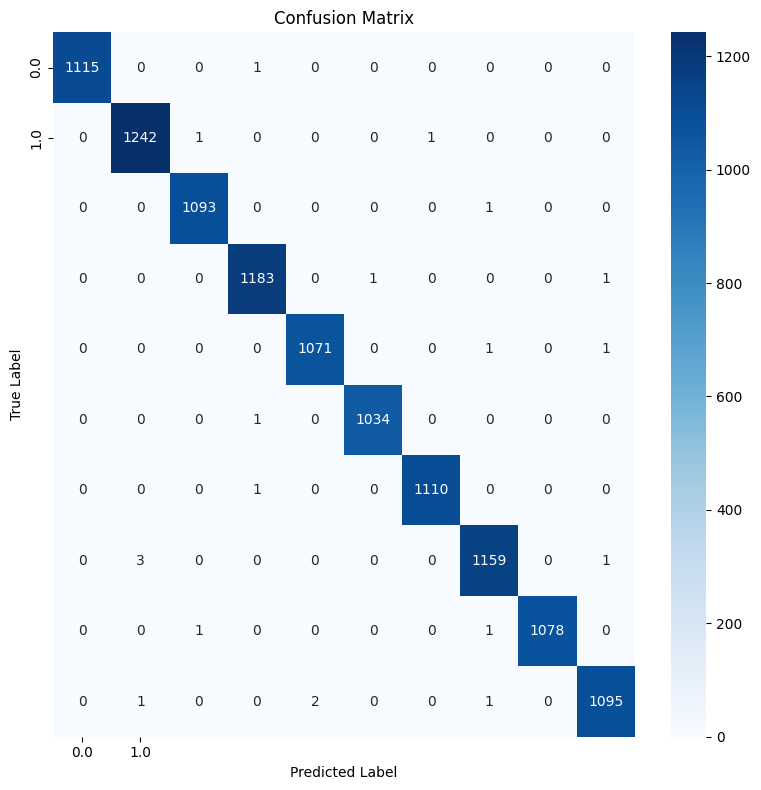

In [29]:
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_val), yticklabels=np.unique(Y_val))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
save_fig("CNN Confusion Matrix")
plt.show()